# Vine-Tweets Dataset

This Notebook describes how to download and work with the [Vine-Tweets Dataset](https://archive.org/details/vine-tweets) which was generated as part of an effort by the [ArchiveTeam](https://archiveteam.org/) to archive videos from the [Vine] social media platform after they announced it was sunsetting the service. Part of this effort involved watching Twitter for tweets mentioning Vine URLs. This data collection from Twitter was performed by [a bot](https://gist.github.com/edsu/88bb252cae8731a17a503d401bba48c4) for a little over a year, during which it collected 127,655,208 tweets that mentioned a vine.

## Setup

First you'll need to have Python3 to use this notebook. Once you've got that installed here are the steps you'll need to follow to get this notebook up and running:
    
    % git checkout https://github.com/edsu/vine-tweets
    % cd vine-tweets
    % pip3 install pipenv
    % pipenv install
    % jupyter notebook Vine-Tweets Dataset.ipynb

The next step is to download the [Vine-Tweets Dataset](https://archive.org/details/vine-tweets) from the Internet Archive. Choose the gzip version of all 13 files. It'll take a bit of time to download as its 1.6G. Once it has finished unzip it into the same directory where you have this Jupyter notebook. 

    % wget https://archive.org/compress/vine-tweets/formats=GZIP&file=/vine-tweets.zip
    % unzip vine-tweets.zip
    % cd vine-tweets
    
## Data Prep
    
To make it easier to process, unarchive and uncompress the files:

    % for f in `ls *.tar.gz`; do tar xvfz $f; done
    
Now your vine-tweets directory should have 13 subdirectories named in a pattern of `YYYYMM` for the year and month that they were collected. Each subdirectory contains a timestamped filename, each of which contains lines of *(tweet id, vine url) tuples, e.g.

    801582593330200577 https://vine.co/v/i3qmOAjOLzd
    801582592747257860 https://vine.co/v/iz635MvhWFF
    801582592634060801 https://vine.co/v/5t0I0hD5tUE
    801582592315314176 https://vine.co/v/i3X3mOzWxpY
    801582592256577536 https://vine.co/v/eYUgJWQlmYm
    801582592235601921 https://vine.co/v/eJAvrYXxv2z
    801582592143204352 https://vine.co/v/eU07l1EJjjJ
    801582591740559360 https://vine.co/v/5t2dQ5qY2hZ
    801582591488966658 https://vine.co/v/5vdjJbVDeqL
    801582591065341952 https://vine.co/v/5t37Wd9DQFm
    
The tweet id can be resolved to a tweet by interpolated it into a URL like this: `https://twitter.com/i/status/{tweet-id}, e.g. https://twitter.com/i/status/801582591065341952.

## Summarize

To process these files its useful to create a generator function that will simply return the list of filenames to process

[Vine]: https://en.wikipedia.org/wiki/Vine_(service)
    

In [1]:
from glob import glob

def get_filenames():
    yield from sorted(glob("vine-tweets/*/*.txt"))

Let's see if it works:

In [2]:
list(get_filenames())[0:5]

['vine-tweets/201611/20161109165738.txt',
 'vine-tweets/201611/20161109175807.txt',
 'vine-tweets/201611/20161109185807.txt',
 'vine-tweets/201611/20161109195810.txt',
 'vine-tweets/201611/20161109205841.txt']

Ok, and here is a simple function that returns the date for a given filename:

In [3]:
import re

def get_date(filename):
    return '%s-%s-%s' % re.search('/(\d{4})(\d{2})(\d{2})', filename).groups()

get_date('vine-tweets/201611/20161110020111.txt')

'2016-11-10'

In order to work with the data it's useful to take one pass through all of it and generate some counts of vines and tweets by day. To save time this is only performed if the `vine-tweets.csv` is not already present.

In [4]:
import os
from collections import Counter, OrderedDict

if not os.path.isfile('vine-tweets.csv'):

    tweets_per_day = Counter()
    vines_per_day = Counter()
    vine_urls = Counter()

    current_date = None

    def save(date, vine_urls):
        tweets = tweets_per_day[date]
        vines = len(vine_urls.keys())
        vines_per_day[date] = vines
    
        print("{} - {:,} vines - {:,} tweets - {:0.2f}".format(
            date, 
            vines,
            tweets,
            vines / tweets
        ))
        with open("vines/%s.csv" % current_date, "w") as output:
            for url, count in vine_urls.items():
                output.write("%s,%s\n" % (url, count))
    
    for filename in get_filenames():
        date = get_date(filename)
    
        if current_date is None:
            current_date = date
        
        if date != current_date:
            save(current_date, vine_urls)
            vine_urls = Counter()
            current_date = date        
        
        for line in open(filename):
            try:
                tweet_id, url = line.strip().split(' ')
                tweets_per_day[date] += 1
                vine_urls[url] += 1
            except ValueError:
                continue
        
    save(date, vine_urls)

    with open("vine-tweets.csv", "w") as output:
        output.write("date,vines,tweets\n")
        for date in vines_per_day.keys():
            output.write("{},{},{}\n".format(date, vines_per_day[date], tweets_per_day[date]))

In [5]:
import pandas

vt = pandas.read_csv('vine-tweets.csv', index_col=0, parse_dates=True)
vt.head()

,vines,tweets
date,,
2016-11-09,38181,250483
2016-11-10,95085,858524
2016-11-11,100961,918512
2016-11-12,110954,1071485
2016-11-13,112435,1211256


Now that we've got our data in a dataframe we can graph the unique vines shared per day, and adding the sunset for the service to chart:

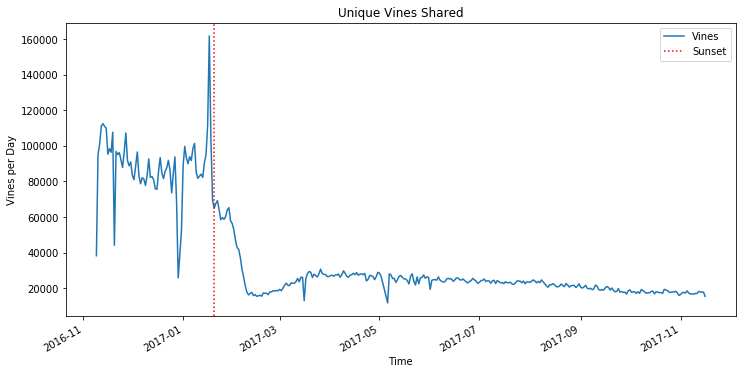

In [6]:
%matplotlib inline

import datetime
sunset = datetime.date(2017, 1, 20)

plot = vt['vines'].plot(title='Unique Vines Shared', figsize=(12, 6))
plot.axvline(sunset, color='red', linestyle='dotted')
plot.set_xlabel('Time')
plot.set_ylabel('Vines per Day')
plot.legend(labels=['Vines', 'Sunset'])

And here are the number of tweets with vines being shared per day:

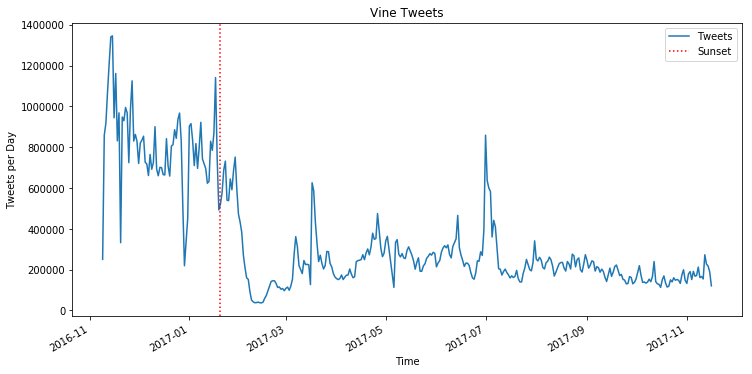

In [7]:
plot = vt['tweets'].plot(title='Vine Tweets', figsize=(12, 6))
plot.set_xlabel('Time')
plot.set_ylabel('Tweets per Day')
plot.axvline(sunset, color='red', linestyle='dotted')
plot.legend(labels=['Tweets', 'Sunset'])

We can also calculate the *variety* of vine sharing, which is the ratio of unique vines shared per day to the total vine tweets that same day:

    variety = vines-per-day / tweets-per-day
    
The idea here is that *variety* is a measure of how diverse the set of vines are relative to the number of tweets that they are found in. If 500 unique vines are found in 1000 tweets the variety is *0.5*. But if only 250 unique vines are found in 1000 tweets then the variety is lower at *0.25*.

In [8]:
vt = vt.assign(variety=lambda row: row.vines / row.tweets)
vt.head()

,vines,tweets,variety
date,,,
2016-11-09,38181,250483,0.152430
2016-11-10,95085,858524,0.110754
2016-11-11,100961,918512,0.109918
2016-11-12,110954,1071485,0.103552
2016-11-13,112435,1211256,0.092825


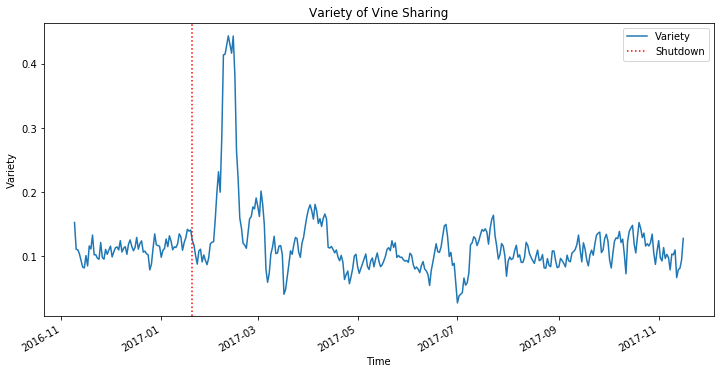

In [9]:
plot = vt['variety'].plot.line(title='Variety of Vine Sharing', figsize=(12, 6))
plot.set_xlabel('Time')
plot.set_ylabel('Variety')
plot.axvline(sunset, color='red', linestyle='dotted')
plot.legend(labels=['Variety', 'Shutdown'])